# Enhancing Context with PDFs: Strategies for Amazon Bedrock Users

- [Introduction](#introduction)
- [Setup](#setup)
- [Method 1: Using Bedrock DocumentBlock API](#method-1-using-bedrock-documentblock-api)
- [Method 2: Using Amazon Bedrock Knowledge Bases](#method-2-using-amazon-bedrock-knowledge-bases)
- [Method 3: Using Anthropic Native PDF Support](#method-3-using-anthropic-native-pdf-support)
- [Method 4: Self-Managed PDF Processing](#method-4-self-managed-pdf-processing)
- [Conclusion](#conclusion)
- [Cleanup](#Cleanup)

## Introduction

When working with large language models like Anthropic's Claude in Amazon Bedrock, providing relevant context is crucial for generating accurate, contextual responses. Often, this contextual information is contained in PDFs - whether they're business documents, reports, invoices, or other materials. This notebook explores four different methods of incorporating PDF content into your prompts for Claude and other Bedrock models, each with its own advantages and use cases.

We'll work with a sample 2-page hotel bill PDF from [this](https://github.com/JensWalter/my-receipts/) public domain dataset. As we explore each method, we'll demonstrate its implementation, highlight its strengths and limitations, and show how Claude responds with the context provided.

## Setup

Let's start by setting up our environment and importing the necessary libraries. We'll also define helper functions to interact with Claude through the Amazon Bedrock API.



In [1]:
!pip install -r requirements.txt -qU --disable-pip-version-check

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.19.0 requires botocore<1.36.4,>=1.36.0, but you have botocore 1.37.11 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.3 which is incompatible.
autogluon-multimodal 1.2 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.2 requires nltk<3.9,>=3.4.5, but you have nltk 3.9.1 which is incompatible.
autogluon-multimodal 1.2 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.


This installs CLI utils for PDF processing, needed by pdf2image. On MacOS poppler can be installed with `brew install poppler`, on Linux you can use your favorite package manager - if it's not apt, for example `yum -y install poppler-utils`.

In [2]:
# For Linux distros that use APT
!which apt-get && sudo apt-get -qq update && sudo apt-get -qqy install poppler-utils

/usr/bin/apt-get
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package poppler-data.
(Reading database ... 13790 files and directories currently installed.)
Preparing to unpack .../00-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package libsqlite3-0:amd64.
Preparing to unpack .../01-libsqlite3-0_3.37.2-2ubuntu0.3_amd64.deb ...
Unpacking libsqlite3-0:amd64 (3.37.2-2ubuntu0.3) ...
Selecting previously unselected package ucf.
Preparing to unpack .../02-ucf_3.0043_all.deb ...
Moving old data out of the way
Unpacking ucf (3.0043) ...
Selecting previously unselected package libpng16-16:amd64.
Preparing to unpack .../03-libpng16-16_1.6.37-3build5_amd64.deb ...
Unpacking libpng16-16:amd64 (1.6.37-3build5) ...
Selecting previously unselected package libxau6:amd64.
Preparing to unpack .../04-libxau6_1%3a1.0.9-1build5_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.9-1build5) ...
Se

In [3]:
# restart kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
import io, os, time, json, uuid, base64
import boto3
from botocore.exceptions import ClientError
from IPython.display import display, Image
from pdf2image import convert_from_path

First, let's setup some variables.

**IMPORTANT:** Replace {INSERT-YOUR-S3-BUCKET} with your own S3 bucket name.
The bucket will be used to store our sample PDF file.

In [2]:
# Replace this with your preferred region (pick a region where Amazon Bedrock provides access to Claude 3.7 Sonnet)
region = "us-west-2"
# Replace this with an existing S3 bucket of your choice in the region configured above
bucket_name = "nsmagt-textract"
# Our sample PDF file
pdf_file_name = "sample.pdf"


Next, we'll create the Bedrock client.

**IMPORTANT:** For this to work, you should have enabled access to Sonnet 3.7 in the AWS console, under "Amazon Bedrock -> Model access", and have configured an AWS region where Claude 3.7 Sonnet is available, such as us-west-2.

In [3]:
# Set up the Bedrock client
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name=region
)

# Define the model ID for Claude
model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"

Included with this notebook is utility.py which provides a number of helper functions we'll load and use when we need them. They're there so they don't clutter up our notebook. Let's start by loading `get_completion`, a simple function to call Claude on our prompt:

In [4]:
from utility import get_completion


Now let's try a prompt to make sure our setup so far, works:

In [5]:
test_response = get_completion(
    prompt="What is Amazon Bedrock?", 
    system_prompt="You are a helpful AI assistant who provides CONCISE, accurate information about AWS services.",
    model_id=model_id,
    bedrock_runtime=bedrock_runtime
)

print(test_response)

Amazon Bedrock is a fully managed service that provides access to leading foundation models (FMs) from companies like AI21 Labs, Anthropic, Cohere, Meta, Mistral AI, and Stability AI through a unified API. It allows you to build generative AI applications without managing the underlying infrastructure, with features for model customization, security controls, and enterprise-grade capabilities.



Now let's upload our sample PDF to the S3 bucket so we can use it in our examples:



In [6]:
# Load the utility function that uploads files to S3
from utility import upload_to_s3

# Upload the file
upload_result = upload_to_s3(pdf_file_name, bucket_name)

Successfully uploaded sample.pdf to s3://nsmagt-textract/sample.pdf



Let's take a quick look at the PDF to understand what we're working with:



Hotel bill - page 1


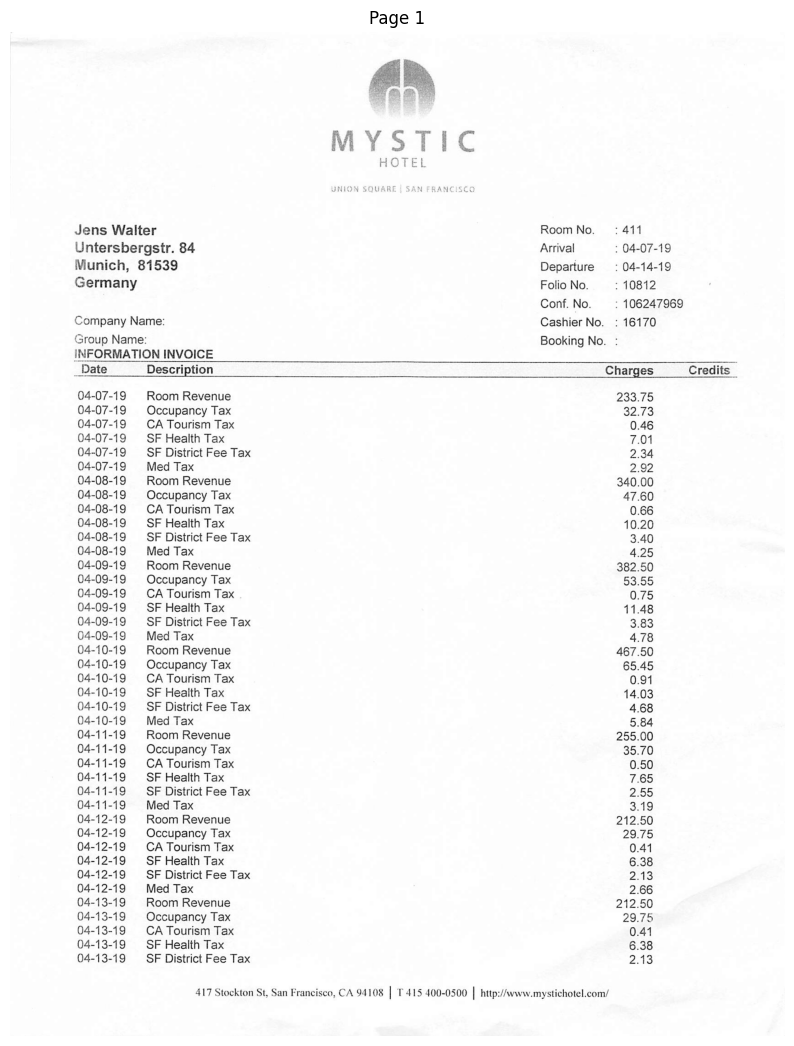

Hotel bill - page 2


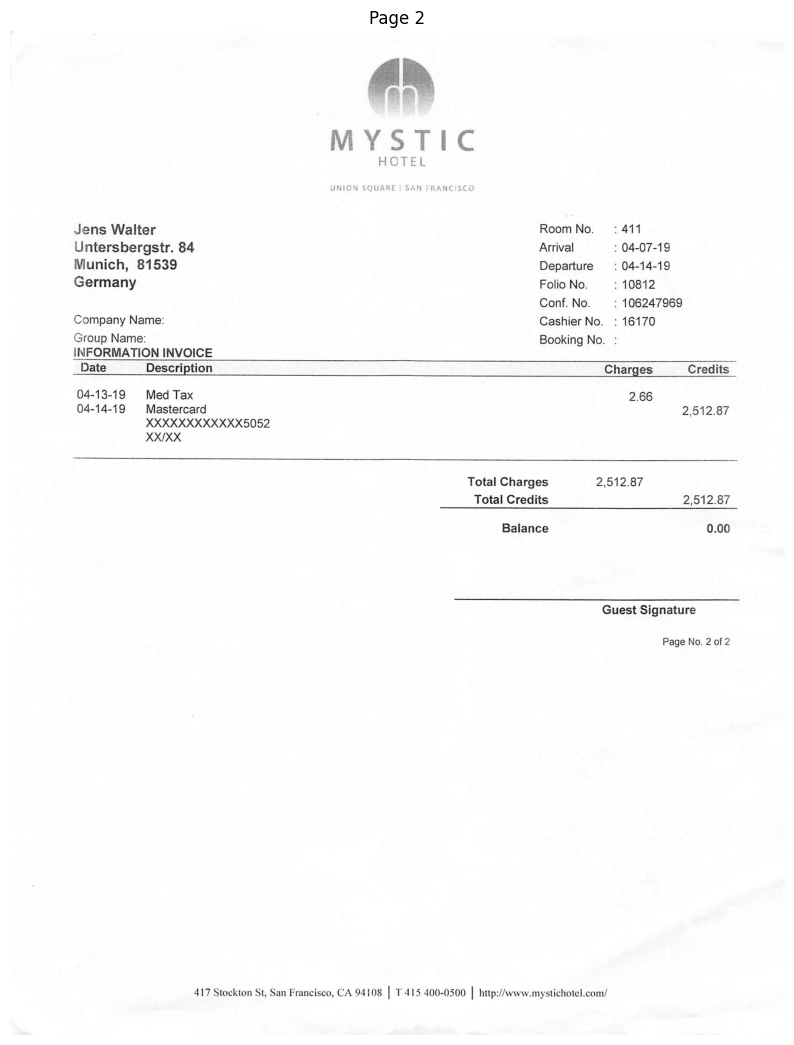

In [7]:
# Load the function to display pages from our PDF
from utility import display_pdf_page

# Display both pages
print("Hotel bill - page 1")
display_pdf_page(pdf_file_name, 0)
print("Hotel bill - page 2")
display_pdf_page(pdf_file_name, 1)


Now, let's explore each method for incorporating PDFs into our Claude conversations.

## Method 1: Using Bedrock DocumentBlock API

The DocumentBlock API provides a direct approach to including document content in your prompts. It automatically extracts text (using OCR if needed) and passes it along with your user prompt, to give the model more complete context about the document.


Define a function to call Claude with our sample PDF as context, using the DocumentBlock API:



In [8]:
# Function to call Claude with our PDF for context with DocumentBlock API
def get_completion_with_document(prompt, pdf_path, system_prompt=None, temperature=0.1, max_tokens=4000):
    """
    Send a prompt to Claude with document context using DocumentBlock
    
    Args:
        prompt (str): The user prompt
        pdf_path (str): Path to the PDF file
        system_prompt (str, optional): System prompt
        temperature (float, optional): Controls randomness
        max_tokens (int, optional): Maximum tokens in the response
        
    Returns:
        str: Claude's response
    """
    
    # Read the PDF file as bytes
    with open(pdf_path, 'rb') as file:
        pdf_bytes = file.read()
    
    # Create the message with document content
    messages = [{
        "role": "user",
        "content": [
            {
                "text": prompt,
            },
            {
                "document": {
                    "name": "sample",
                    "format": "pdf",
                    "source": {
                        "bytes": pdf_bytes
                    }
                }
            }
        ]
    }]
    
    # Create the request parameters
    converse_params = {
        "modelId": model_id,
        "messages": messages,
        "inferenceConfig": {"maxTokens": max_tokens, "temperature": temperature}
    }
    
    # Add system prompt if provided
    if system_prompt:
        converse_params["system"] = [{"text": system_prompt}]  # System needs to be a list of dictionaries
    
    try:
        # Call the Converse API
        response = bedrock_runtime.converse(**converse_params)
        
        # Extract the response
        ai_message = response["output"]["message"]
        text_message = ai_message["content"][0]["text"]
        
        return text_message
        
    except Exception as e:
        print(f"Error type: {type(e)}")
        print(f"Error message: {str(e)}")
        return None


A common use case for providing PDF-based context to language models, is to ask questions about the content of the document. Let's ask Claude some questions to determine how well Claude understands the context provided through the DocumentBlock API:


In [9]:
# Let's ask some questions about the document using DocumentBlock
questions = [
    "What was the check-in date of the hotel stay?",
    "What was the total cost of occupancy tax for the stay?",
    "Describe the hotel logo on the bill."
]

for question in questions:
    print(f"Question: {question}")
    
    answer = get_completion_with_document(
        prompt=f"Answer the following question based on the provided document: {question}",
        pdf_path=pdf_file_name,
        system_prompt="You are a helpful assistant analyzing document content. Be concise and precise."
    )
    
    print(f"Answer: {answer}")
    print("-" * 70)

Question: What was the check-in date of the hotel stay?
Answer: Based on the invoice document, the check-in date (Arrival) was 04-07-19 (April 7, 2019).
----------------------------------------------------------------------
Question: What was the total cost of occupancy tax for the stay?
Answer: Based on the invoice, the total occupancy tax for the stay was the sum of the daily occupancy tax charges:
$32.73 + $47.60 + $53.55 + $65.45 + $35.70 + $29.75 + $29.76 = $294.54

This represents the occupancy tax charged for each day of the guest's stay from April 7-14, 2019.
----------------------------------------------------------------------
Question: Describe the hotel logo on the bill.
Answer: Based on the document, I can see that the hotel logo appears at the top of the invoice pages with the text "YSW HOTEL" visible. The logo seems to have some stylized or decorative elements, but the document doesn't provide enough clear detail to describe the specific design elements of the logo beyon

This works, and it's fast. It's not entirely accurate though:
- The OCR performed has an issue due to imperfect scan quality - Claude gets the last occupancy tax line wrong most of the time, due to a slight crease in the paper
- Claude cannot describe the hotel logo on the document
- Claude gets the hotel name in the logo wrong as the OCR process provides it with an incorrect spelling, possibly due to the lighter color used for the logo


### Pros and Cons of DocumentBlock API

**Pros:**
- Simple integration with a single API call
- Provides the full document context to the model at once
- No need to manage separate knowledge base infrastructure
- Lower end-to-end latency compared to some other approaches

**Cons:**
- OCR quality depends on the underlying document quality
- Doesn't provide visual context to Claude (images, tables)

## Method 2: Using Amazon Bedrock Knowledge Bases

Amazon Bedrock Knowledge Bases provide a Retrieval-Augmented Generation (RAG) solution that allows you to upload documents (including PDFs) and then use this data to enhance model responses. The system automatically processes documents, chunks them, and creates embeddings for efficient retrieval when answering queries. More info in the [Knowledge Bases documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base.html).

Let's set up a Knowledge Base and upload our sample PDF:

In [10]:
# Create a Bedrock Knowledge Base client
bedrock_kb = boto3.client('bedrock-agent', region_name=region)
s3 = boto3.client('s3', region_name=region)

# Generate a unique name for our knowledge base
kb_name = f"hotel-docs-kb-{str(uuid.uuid4())[:8]}"


The next cell creates the Opensearch vector database takes a few minutes to complete.

In [11]:
# Import functions from utility.py, for creating the necessary infrastructure ->
# Opensearch Serverless, and Bedrock KB
from utility import (
    create_bedrock_kb_execution_role,
    create_opensearch_vector_store,
    wait_for_kb_status
)

# Create the necessary IAM role for the Knowledge Base
kb_role = create_bedrock_kb_execution_role(bucket_name=bucket_name, region=region)
kb_role_arn = kb_role['Role']['Arn']
print(f"Created Knowledge Base execution role: {kb_role_arn}")

# Create an OpenSearch Serverless vector store for our Knowledge Base
vector_store_id = create_opensearch_vector_store(region=region)
print(f"Created OpenSearch vector store with ID: {vector_store_id}")

Waiting for IAM role to be available...
Created Knowledge Base execution role: arn:aws:iam::944626235989:role/BedrockKBRole-56832ff5
Creating OpenSearch vector store collection kb-vector-store-3601f322...
Collection status: ACTIVE

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'bedrock-kb-index'}
Waiting 60 seconds for index creation to complete...
Successfully created index bedrock-kb-index
Created OpenSearch vector store with ID: p5lc8pxr7cl1dsaoxe23


In [12]:
# Create a Knowledge Base using the OpenSearch vector store
response = bedrock_kb.create_knowledge_base(
    name=kb_name,
    description="Knowledge base for hotel documentation",
    roleArn=kb_role_arn,
    knowledgeBaseConfiguration={
        'type': 'VECTOR',
        'vectorKnowledgeBaseConfiguration': {
            'embeddingModelArn': f'arn:aws:bedrock:{region}::foundation-model/amazon.titan-embed-text-v1'
        }
    },
    storageConfiguration={
        'type': 'OPENSEARCH_SERVERLESS',
        'opensearchServerlessConfiguration': {
            'collectionArn': f'arn:aws:aoss:{region}:{boto3.client("sts").get_caller_identity()["Account"]}:collection/{vector_store_id}',
            # Add the required field mapping
            'fieldMapping': {
                'vectorField': 'vector_field',
                'textField': 'text_field',
                'metadataField': 'metadata'
            },
            # Add the required vector index name
            'vectorIndexName': 'bedrock-kb-index'
        }
    }
)

knowledge_base_id = response['knowledgeBase']['knowledgeBaseId']
print(f"Created Knowledge Base with ID: {knowledge_base_id}")

Created Knowledge Base with ID: NPDX4PWWH3


In [13]:
# Create a data source for our S3 bucket
response = bedrock_kb.create_data_source(
    knowledgeBaseId=knowledge_base_id,
    name='hotel-bills',
    description='Hotel bills',
    dataSourceConfiguration={
        'type': 'S3',
        's3Configuration': {
            'bucketArn': f'arn:aws:s3:::{bucket_name}',
            'inclusionPrefixes': [pdf_file_name]
        }
    },
    vectorIngestionConfiguration={
        'chunkingConfiguration': {
            'chunkingStrategy': 'FIXED_SIZE',
            'fixedSizeChunkingConfiguration': {
                'maxTokens': 300,
                'overlapPercentage': 20
            }
        }
    }
)

data_source_id = response['dataSource']['dataSourceId']
print(f"Created data source with ID: {data_source_id}")

Created data source with ID: AXBH5TXE00


In [14]:
# Start the ingestion job to process our PDF
response = bedrock_kb.start_ingestion_job(
    knowledgeBaseId=knowledge_base_id,
    dataSourceId=data_source_id
)

ingestion_job_id = response['ingestionJob']['ingestionJobId']
print(f"Started ingestion job with ID: {ingestion_job_id}")

Started ingestion job with ID: HXC12THYXI


In [15]:
# Wait for the Knowledge Base to be active and data to be ingested
print("Waiting for Knowledge Base to be ready and data to be ingested...")
wait_for_kb_status(bedrock_kb, knowledge_base_id, 'ACTIVE')

# Check ingestion job status
def check_ingestion_status(kb_id, ds_id, job_id):
    response = bedrock_kb.get_ingestion_job(
        knowledgeBaseId=kb_id,
        dataSourceId=ds_id,
        ingestionJobId=job_id
    )
    return response['ingestionJob']['status']

# Wait for ingestion to complete
ingestion_status = check_ingestion_status(knowledge_base_id, data_source_id, ingestion_job_id)
while ingestion_status in ['STARTING', 'IN_PROGRESS']:
    print(f"Ingestion status: {ingestion_status}. Waiting...")
    time.sleep(30)
    ingestion_status = check_ingestion_status(knowledge_base_id, data_source_id, ingestion_job_id)

print(f"Ingestion completed with status: {ingestion_status}")
if ingestion_status == 'COMPLETE':
    print("Knowledge Base is ready to use!")
else:
    print(f"Warning: Ingestion ended with status {ingestion_status}")

# Wait a bit longer for data processing, or retrieval results will still be empty
print(f"Waiting for ingestion results to process...")
time.sleep(30)
print(f"Knowledge Base is ready to be queried!")

Waiting for Knowledge Base to be ready and data to be ingested...
Waiting for Knowledge Base to reach ACTIVE status...
Knowledge Base is now ACTIVE
Ingestion status: STARTING. Waiting...
Ingestion completed with status: COMPLETE
Knowledge Base is ready to use!
Waiting for ingestion results to process...
Knowledge Base is ready to be queried!


In [16]:
# Create the bedrock-agent-runtime client for querying the Knowledge Base
bedrock_kb_runtime = boto3.client('bedrock-agent-runtime', region_name=region)

def query_knowledge_base(query_text, kb_id, num_results=5):
    """
    Query a Bedrock Knowledge Base
    
    Args:
        query_text (str): The query text
        kb_id (str): Knowledge Base ID
        num_results (int): Number of results to return
        
    Returns:
        dict: The query response
    """
    try:
        response = bedrock_kb_runtime.retrieve(
            knowledgeBaseId=kb_id,
            retrievalQuery={
                'text': query_text
            },
            retrievalConfiguration={
                'vectorSearchConfiguration': {
                    'numberOfResults': num_results
                }
            }
        )
        return response
    except ClientError as e:
        print(f"Error querying Knowledge Base: {e}")
        raise

In [17]:
# Function to query Claude with knowledge base context
def query_claude_with_kb(user_question, kb_id):
    """
    Query Claude with context from a Knowledge Base
    
    Args:
        user_question (str): The question to ask
        kb_id (str): Knowledge Base ID
        
    Returns:
        str: Claude's response
    """
    # First retrieve relevant information from the Knowledge Base
    kb_response = query_knowledge_base(user_question, kb_id)
    
    # Extract the retrieved passages
    passages = []
    if kb_response and 'retrievalResults' in kb_response:
        for result in kb_response['retrievalResults']:
            passages.append(result['content']['text'])
    
    # Construct the prompt with context
    context = "\n\n".join(passages)
    
    prompt = f"""I need information from the provided context below.

Context:
{context}

Question: {user_question}

Please answer based only on the information in the context. If the context doesn't contain relevant information, please say so."""
    
    # Get Claude's response
    claude_response = get_completion(
        prompt=prompt,
        model_id=model_id,
        bedrock_runtime=bedrock_runtime
    )
    
    return claude_response



Let's test it with our standard set of questions:



In [18]:
# Test questions using the Knowledge Base context
questions = [
    "What was the check-in date of the hotel stay?",
    "What was the total cost of occupancy tax for the stay?",
    "Describe the hotel logo on the bill."
]

for question in questions:
    print(f"Question: {question}")
    answer = query_claude_with_kb(question, knowledge_base_id)
    print(f"Answer: {answer}")
    print("-" * 70)


Question: What was the check-in date of the hotel stay?
Answer: Based on the context, the check-in date (Arrival) was 04-07-19 (April 7, 2019).
----------------------------------------------------------------------
Question: What was the total cost of occupancy tax for the stay?
Answer: Based on the provided context, I cannot determine the total cost of occupancy tax for the stay. While there is a line item for "MedTax" on 04-13-19, the specific amount for this tax is not clearly indicated in the context. The context shows a total charges amount of 2,512.87, but it doesn't break down how much of this was specifically for occupancy tax.
----------------------------------------------------------------------
Question: Describe the hotel logo on the bill.
Answer: Based on the context provided, there is no detailed description of the hotel logo on the bill. The document shows "MYSTIC HOTEL" in text format (appearing as "MYSTIA HOTEL" or similar variations in some places due to text recognit

RAG shines when retrieving context from a large collection of documents, but the context it retrieves is not as rich as with methods that use the full document for context. So here, results aren't great:
- The Knowledge Base successfully retrieves the check-in date, as it's a discrete piece of information that can be pulled from a single context chunk
- It has less success retrieving the occupancy tax numbers - these values are in different places in the PDF and are likely split across chunks - Claude tries to make the most of the provided context but it doesn't understand what it's receiving
- We're using text-only RAG here, so there's no visual context shared to Claude for completing the logo task.


### Pros and Cons of Knowledge Bases

**Pros:**
- Automatically processes and indexes documents for efficient retrieval
- Handles large document collections well
- Managed service with minimal operational overhead

**Cons:**
- Context is not as rich - no formatting/layout information or visual context
- Higher latency due to two-step process - retrieval (which includes running embedding models), then generation
- Limited control over exactly how the documents are chunked and processed
- Visual elements of PDFs are not considered in the retrieval
- Not great for our use case of document chat

## Method 3: Using Anthropic Native PDF Support

Anthropic's Claude has native support for handling PDFs directly through the native API, hosted by Anthropic. PDF support on that API leverages Claude's multimodal capabilities to process PDF files, allowing it to understand both the content and visual layout of the document. It's been designed with our document chat use case in mind.

This example will only work if you have an Anthropic API key. If you don't, that's fine, skip the next two code cells and review the pre-generated output below the second cell.

Now let's create a function to use PDF support on Anthropic's API:

In [19]:
import anthropic

# AWS Secrets Manger is a great place to store external api keys securely
# Or, just place it in the ANTHROPIC_API_KEY env variable
if 'ANTHROPIC_API_KEY' in os.environ and os.environ['ANTHROPIC_API_KEY']:
    api_key = os.environ['ANTHROPIC_API_KEY']
else:
    secrets_manager = boto3.client("secretsmanager", region_name = region)
    secret_name = "anthropic"

    response = secrets_manager.get_secret_value(SecretId=secret_name)
    secret_json = json.loads(response["SecretString"])
    api_key = secret_json["api_key"]

# Initialize the Anthropic client
anthropic_client = anthropic.Anthropic(
    api_key=api_key
)

# Function to call Claude with direct PDF support using Anthropic's native API
def get_completion_with_anthropic_pdf(prompt, pdf_path, model="claude-3-7-sonnet-20250219", max_tokens=4000):
    """
    Send a prompt to Claude with a PDF file using Anthropic's native API
    
    Args:
        prompt (str): The user prompt
        pdf_path (str): Path to the PDF file
        model (str): Anthropic model ID
        max_tokens (int): Maximum tokens in the response
        
    Returns:
        str: Claude's response
    """
    
    # Read and encode the PDF file
    with open(pdf_path, "rb") as f:
        pdf_data = base64.b64encode(f.read()).decode("utf-8")
    
    # Create the message with PDF content
    try:
        message = anthropic_client.messages.create(
            model=model,
            max_tokens=max_tokens,
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "document",
                            "source": {
                                "type": "base64",
                                "media_type": "application/pdf",
                                "data": pdf_data
                            }
                        },
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }
            ]
        )
        
        # Extract the response text
        return message.content[0].text
    except Exception as e:
        print(f"Error calling Anthropic API: {e}")
        return None


Let's test it with our standard set of questions:



In [20]:
# Let's ask some questions using Anthropic's native PDF support
questions = [
    "What was the check-in date of the hotel stay?",
    "What was the total cost of occupancy tax for the stay?",
    "Describe the hotel logo on the bill."
]

for question in questions:
    print(f"Question: {question}")
    
    answer = get_completion_with_anthropic_pdf(
        prompt=f"Answer the following question based on the provided PDF document: {question}",
        pdf_path=pdf_file_name
    )
    
    print(f"Answer: {answer}")
    print("-" * 70)

Question: What was the check-in date of the hotel stay?
Answer: Based on the hotel invoice from Mystic Hotel in San Francisco, the check-in date (arrival date) was April 7, 2019 (04-07-19), as shown in the document.
----------------------------------------------------------------------
Question: What was the total cost of occupancy tax for the stay?
Answer: Based on the hotel invoice from Mystic Hotel in San Francisco, the total cost of occupancy tax for Jens Walter's stay from April 7-14, 2019 can be calculated by adding up all the occupancy tax line items:

April 7: $32.73
April 8: $47.60
April 9: $53.55
April 10: $65.45
April 11: $35.70
April 12: $29.75
April 13: $29.75

The total occupancy tax for the entire stay was $294.53.
----------------------------------------------------------------------
Question: Describe the hotel logo on the bill.
Answer: Based on the invoice, the Mystic Hotel logo appears at the top of each page. It consists of a circular or rounded design with what app

Claude's answers are entirely accurate this way:
- Claude finds the correct check-in date
- The occupancy tax is correctly extracted and calculated
- The logo is well-described and there are no problematic OCR outputs visible in the output

Here's pre-generated output using the Anthropic native API (in case you don't have an Anthropic API key):
```
Question: What was the check-in date of the hotel stay?
Answer: Based on the hotel invoice, the check-in date (arrival date) was April 7, 2019 (shown as 04-07-19 in the document). This information appears in the header section of the invoice from the Mystic Hotel in San Francisco.
    -------------------------------------------------------------------
Question: What was the total cost of occupancy tax for the stay?
Answer: Based on the hotel invoice from Mystic Hotel, the total cost of occupancy tax for Jens Walter's stay from April 7-14, 2019 was the sum of the daily occupancy tax charges:

$32.73 (April 7)
$47.60 (April 8)
$53.55 (April 9)
$65.45 (April 10)
$35.70 (April 11)
$29.75 (April 12)
$29.75 (April 13)

This totals to $294.53 for the entire stay in occupancy tax.
    -------------------------------------------------------------------
Question: Describe the hotel logo on the bill.
Answer: The hotel invoice shows the Mystic Hotel logo, which appears as a minimalist design with the letter "m" inside a circular element. The logo is displayed at the top of the invoice with "MYSTIC HOTEL" written below it in uppercase letters, followed by "UNION SQUARE | SAN FRANCISCO" indicating the hotel's location. The logo has a sleek, modern aesthetic that fits with the upscale nature of the hotel.
```


### Pros and Cons of Anthropic Native PDF Support

**Pros:**
- Direct handling of PDF files without preprocessing
- Provides Claude visual layout and formatting information
- Single API call implementation
- Multimodal capabilities - Claude understands tables, charts, and visual elements
- Best accuracy for document chat due to the combination of high-performance text extraction with visual context
- Fast

**Cons:**
- Not available on Amazon Bedrock today

## Method 4: Self-Managed PDF Processing

To implement a similar solution for document chat as method 3, but using Amazon Bedrock instead of the Anthropic native API, we can implement a self-managed solution that extracts both text and images from PDFs and provides them to Claude separately. This approach gives us flexibility in handling documents. The example can easily be adapted to only provide the context that Claude needs for a particular type of PDF source. For complex files with visual information as well as (scanned) text, we can send both modalities. If a document is text-only, we can only extract text. If the document is visual (like an image or diagram) we can only send Claude images. This way we optimize latency, input tokens, and complexity.

First, let's define a function to extract text from our document using the AWS-managed text extraction service, Amazon Textract:

In [21]:
from utility import textract

# Function to extract text from our PDF using Amazon Textract
def extract_text_from_pdf(file_name, bucket_name):
    """
    Extract text from a PDF file using AWS Textract
    
    Args:
        file_name (str): Name of the PDF file
        bucket_name (str): S3 bucket where the file is stored
        
    Returns:
        str: Extracted text
    """
    # Using the provided textract helper function
    extracted_text = textract(file_name, bucket_name, region)
    return extracted_text


Started Textract job 6006f9ec3b1a1fba22fea1a0faa3c2a73a1009cd991c0e408a6b3996e861196d, waiting for completion...
Extracted 2118 characters of text
Sample of extracted text:
MYSTIC
HOTEL
UNION SQUARE SAN FRANCISCO
Jens Walter
Room No.
: 411
Untersbergstr. 84
Arrival
: 04-07-19
Munich, 81539
Departure
: 04-14-19
Germany
Folio No.
: 10812
Conf. No.
: 106247969
Company Name:
Cashier No.
: 16170
Group Name:
Booking No. :
INF...


Let's use the function to extract text from our sample PDF. This will take a few minutes:


In [22]:
extracted_text = extract_text_from_pdf(pdf_file_name, bucket_name)

# Print a sample of the extracted text
print(f"Extracted {len(extracted_text)} characters of text")
print("Sample of extracted text:")
print(extracted_text[:250] + "...")

Started Textract job 4146574482e3baca3c782dbf240fc6e16cb430127616d406689674fca7127e66, waiting for completion...
Extracted 2118 characters of text
Sample of extracted text:
MYSTIC
HOTEL
UNION SQUARE SAN FRANCISCO
Jens Walter
Room No.
: 411
Untersbergstr. 84
Arrival
: 04-07-19
Munich, 81539
Departure
: 04-14-19
Germany
Folio No.
: 10812
Conf. No.
: 106247969
Company Name:
Cashier No.
: 16170
Group Name:
Booking No. :
INF...



Now let's create a function to call Claude, with PDF pages converted to images using pdf2image, and the text extracted with Textract:


In [24]:
# Function to call Claude with both images and text
def get_completion_with_images_and_text(prompt, pdf_path, bucket_name, system_prompt=None, temperature=0.0, max_tokens=2000):
    """
    Send a prompt to Claude with both images and extracted text
    
    Args:
        prompt (str): The user prompt
        pdf_path (str): Path to the PDF file
        bucket_name (str): S3 bucket name for Textract
        system_prompt (str, optional): System prompt
        temperature (float, optional): Controls randomness
        max_tokens (int, optional): Maximum tokens in the response
        
    Returns:
        str: Claude's response
    """
    
    # Convert PDF to images
    images = convert_from_path(pdf_path)
    
    # Prepare content list with the prompt that includes extracted text
    content_items = [
        {
            "text": f"""<extracted_text_context>
{extracted_text}
</extracted_text_context>

{prompt}"""
        }
    ]
    
# Add each page image to the content
    for i, img in enumerate(images):
        # Convert PIL Image to bytes
        img_byte_arr = io.BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_bytes = img_byte_arr.getvalue()

        # Add raw bytes to content items
        content_items.append({
            "image": {
                "format": "png", 
                "source": {"bytes": img_bytes}
            }
        })
    
    # Set up the request parameters
    inference_config = {
        "temperature": temperature,
        "maxTokens": max_tokens,
        "topP": 0.9
    }
    
    converse_params = {
        "modelId": model_id,
        "messages": [
            {"role": "user", "content": content_items}
        ],
        "inferenceConfig": inference_config
    }
    
    if system_prompt:
        converse_params["system"] = [{"text": system_prompt}]
    
    try:
        response = bedrock_runtime.converse(**converse_params)
        text_content = response['output']['message']['content'][0]['text']
        return text_content
    except ClientError as err:
        message = err.response['Error']['Message']
        print(f"A client error occurred: {message}")
        return None


Let's test it with our standard set of questions:



In [25]:
# Let's ask some questions using both images and extracted text
questions = [
    "What was the check-in date of the hotel stay?",
    "What was the total cost of occupancy tax for the stay?",
    "Describe the hotel logo on the bill."
]

for question in questions:
    print(f"Question: {question}")
    
    answer = get_completion_with_images_and_text(
        prompt=f"Answer the following question based on the provided hotel documentation: {question}",
        pdf_path=pdf_file_name,
        bucket_name=bucket_name,
        system_prompt="You are a helpful assistant analyzing document content. You have access to both the document text and images. Use both to provide accurate, detailed answers."
    )
    
    print(f"Answer: {answer}")
    print("-" * 70)

Question: What was the check-in date of the hotel stay?
Answer: Based on the hotel invoice provided, the check-in date (arrival date) was April 7, 2019 (04-07-19). This information is clearly indicated in the header section of the invoice next to "Arrival" and is also reflected in the first date entries of the itemized charges that begin on that same date.
----------------------------------------------------------------------
Question: What was the total cost of occupancy tax for the stay?
Answer: Based on the hotel invoice for Jens Walter's stay at the Mystic Hotel in San Francisco, the total cost of occupancy tax for the entire stay was $294.53. This is calculated by adding up all the occupancy tax charges from April 7-13, 2019:

- 04-07-19: $32.73
- 04-08-19: $47.60
- 04-09-19: $53.55
- 04-10-19: $65.45
- 04-11-19: $35.70
- 04-12-19: $29.75
- 04-13-19: $29.75

Total: $294.53

The occupancy tax varied each day because it was calculated based on the room revenue, which changed through

Accuracy is great. All the facts are correctly retrieved due to the combination of highly accurate text extraction with Textract, and visual context provided to Claude through pdf2image. Claude also shows great visual awareness of the layout and hotel logo. There's a bit of delay waiting for the Textract job to complete though, so depending on the use case this part of the context you can leave text extraction out, or some simpler means of text extraction can be implemented.


### Pros and Cons of Self-Managed PDF Processing

**Pros:**
- Comprehensive context, combining visual and textual information
- High accuracy
- Complete control over document processing, providing greatest flexibility for customization

**Cons:**
- Higher latency (especially when combining text extraction with sending Claude PDF pages as images)
- More code to manage (complexity and higher operational burden)
- May require additional services for text extraction
- Higher token usage, which can increase costs
- A maximum of 20 images (ie. PDF pages) can be included with each Bedrock request

## Conclusion

We've explored four different methods for incorporating PDF content into conversations with Claude through Amazon Bedrock:

1. **DocumentBlock API**: Provides a simpler, more direct way to include document content in your prompts. For quick context from simple documents, without needing additional infrastructure. Not great with OCR or using visual context such as tables or images. 

2. **Knowledge Bases**: Best for large document collections where you need to find relevant information across multiple documents. Offers scalable, managed infrastructure with semantic search capabilities, but the model has less context to work with per request than other methods and is therefore not ideal for situations where we need the full context from 1 or a few documents (such as our document chat scenario.

3. **Anthropic Native PDF Support**: High accuracy, scalability (up to 100 page PDF files) and simplicity, but not available on Amazon Bedrock currently.

4. **Self-Managed PDF Processing**: Offers great flexibility, accuracy and control by separately handling text extraction and image processing. Best for complex documents where precise control over processing is needed, but scalability is less than Anthropic's native PDF support.

The best method for your use case will depend on factors like:

- The number and size of documents you need to process
- Whether visual layout is important
- Your latency and cost requirements
- The complexity of information retrieval needed

By understanding these different approaches, you can choose the most appropriate method to enhance Claude's abilities with document context, leading to more accurate and helpful responses for your specific use cases.


## Cleanup

Don't forget to remove the persistent configurations we've created in this notebook:

In [19]:
# Cleanup all AWS resources created in this notebook
print("Starting cleanup of AWS resources...")

# 1. Delete the Knowledge Base
try:
    print(f"Deleting Knowledge Base {knowledge_base_id}...")
    bedrock_kb.delete_knowledge_base(knowledgeBaseId=knowledge_base_id)
    print("Knowledge Base deleted successfully")
except Exception as e:
    print(f"Error deleting Knowledge Base: {e}")

# 2. Delete the OpenSearch Serverless collection
try:
    # First get the collection details to get the name
    aoss = boto3.client('opensearchserverless', region_name=region)
    response = aoss.batch_get_collection(ids=[vector_store_id])
    collection_name = response['collectionDetails'][0]['name']
    
    # Delete the collection
    print(f"Deleting OpenSearch collection {vector_store_id}...")
    aoss.delete_collection(id=vector_store_id)
    print("OpenSearch collection deletion initiated")
    
    # Delete the security policies
    print("Deleting OpenSearch security policies...")
    
    # Get policy names based on collection name
    encryption_policy_name = f"{collection_name}-enc"
    network_policy_name = f"{collection_name}-network"
    access_policy_name = f"{collection_name}-access"
    
    # Delete policies
    try:
        aoss.delete_security_policy(name=encryption_policy_name, type='encryption')
        print(f"Deleted encryption policy {encryption_policy_name}")
    except Exception as e:
        print(f"Error deleting encryption policy: {e}")
        
    try:
        aoss.delete_security_policy(name=network_policy_name, type='network')
        print(f"Deleted network policy {network_policy_name}")
    except Exception as e:
        print(f"Error deleting network policy: {e}")
    
    # Delete access policy - according to the docs, this also needs a type parameter
    try:
        aoss.delete_access_policy(name=access_policy_name, type='data')
        print(f"Deleted access policy {access_policy_name}")
    except Exception as e:
        print(f"Error deleting access policy: {e}")
    
    print("OpenSearch security policies deletion completed")
except Exception as e:
    print(f"Error deleting OpenSearch resources: {e}")

# 3. Delete the IAM roles
try:
    iam = boto3.client('iam')
    
    # Get the role name from the ARN
    kb_role_name = kb_role_arn.split('/')[-1]
    
    # First detach all policies
    print(f"Deleting IAM role policies for {kb_role_name}...")
    
    # List and delete inline policies
    inline_policies = iam.list_role_policies(RoleName=kb_role_name)
    for policy_name in inline_policies.get('PolicyNames', []):
        iam.delete_role_policy(RoleName=kb_role_name, PolicyName=policy_name)
    
    # Delete the role
    print(f"Deleting IAM role {kb_role_name}...")
    iam.delete_role(RoleName=kb_role_name)
    print("IAM role deleted successfully")
except Exception as e:
    print(f"Error deleting IAM role: {e}")

print("Cleanup completed!")

Starting cleanup of AWS resources...
Deleting Knowledge Base PFLOXTDWBH...
Knowledge Base deleted successfully
Deleting OpenSearch collection eyyojax094aujn6jtudd...
OpenSearch collection deletion initiated
Deleting OpenSearch security policies...
Deleted encryption policy kb-vector-store-2aecc46d-enc
Deleted network policy kb-vector-store-2aecc46d-network
Deleted access policy kb-vector-store-2aecc46d-access
OpenSearch security policies deletion completed
Deleting IAM role policies for BedrockKBRole-9cb18c92...
Deleting IAM role BedrockKBRole-9cb18c92...
IAM role deleted successfully
Cleanup completed!
